# ImageNet 사용
- 입력 이미지: 96x96x3 RGB (grayscale -> 3채널로 복제)
- 사전 학습된 ImageNet 가중치 사용
- GAP(GlobalAveragePooling) + Dropout + Dense
- preprocess_input()

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-16 00:48:03.364844: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 00:48:03.398618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-16 00:48:03.398649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-16 00:48:03.400427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-16 00:48:03.406403: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input

IMG_SIZE=96
BATCH_SIZE=32
DATA_PATH="../../data/processed/03_AIHUB_dataset/cropped_data"

datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED,
    subset="training"
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
    seed=SEED,
    subset="validation"
)

Found 131811 images belonging to 2 classes.
Found 32951 images belonging to 2 classes.


In [3]:
# 비율이 조금 꺠졌기 때문에 class_weight 사용
# class_weight 계산
from sklearn.utils.class_weight import compute_class_weight

labels=train_generator.classes

class_weights=compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights=dict(enumerate(class_weights))

print("class_weights:", class_weights)

class_weights: {0: 1.184498562185478, 1: 0.8652308621391344}


In [4]:
# ResNet50V2 모델 정의

In [5]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model=ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
base_model.trainable=False  # 전이학습 backbone freeze

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(64, activation="relu")(x)
x=Dropout(0.25)(x)
output=Dense(1, activation="sigmoid")(x)

model=Model(inputs=base_model.input, outputs=output)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

2025-06-16 00:50:11.035522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 00:50:11.035622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 00:50:11.035668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 00:50:11.245438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-16 00:50:11.245495: I external/local_xla/xla/stream_executor

94668760/94668760 [==============================] - 3s 0us/step


In [6]:
esc=EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, verbose=1)
checkpoint=ModelCheckpoint(filepath="temp_model/02_resnet50v2/best_model.keras",
                           monitor="val_loss", save_best_only=True, verbose=1)

history=model.fit(train_generator, validation_data=val_generator,
                  epochs=30, callbacks=[esc, reduce_lr, checkpoint], class_weight=class_weights)

Epoch 1/30


2025-06-16 00:51:12.737899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-16 00:51:13.051933: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-16 00:51:13.051972: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-16 00:51:13.052035: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-16 00:51:14.819247: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-16 00:51:14.819285: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

4120/4120 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.8004
Epoch 1: val_loss improved from inf to 0.37387, saving model to temp_model/02_resnet50v2/best_model.keras
4120/4120 [==============================] - 70s 16ms/step - loss: 0.4665 - accuracy: 0.8004 - val_loss: 0.3739 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 2/30
4119/4120 [============================>.] - ETA: 0s - loss: 0.4462 - accuracy: 0.8114
Epoch 2: val_loss improved from 0.37387 to 0.36707, saving model to temp_model/02_resnet50v2/best_model.keras
4120/4120 [==============================] - 64s 15ms/step - loss: 0.4462 - accuracy: 0.8114 - val_loss: 0.3671 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 3/30
4120/4120 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8155
Epoch 3: val_loss improved from 0.36707 to 0.36026, saving model to temp_model/02_resnet50v2/best_model.keras
4120/4120 [==============================] - 64s 16ms/step - loss: 0.4400 - accuracy: 0.8155 - 

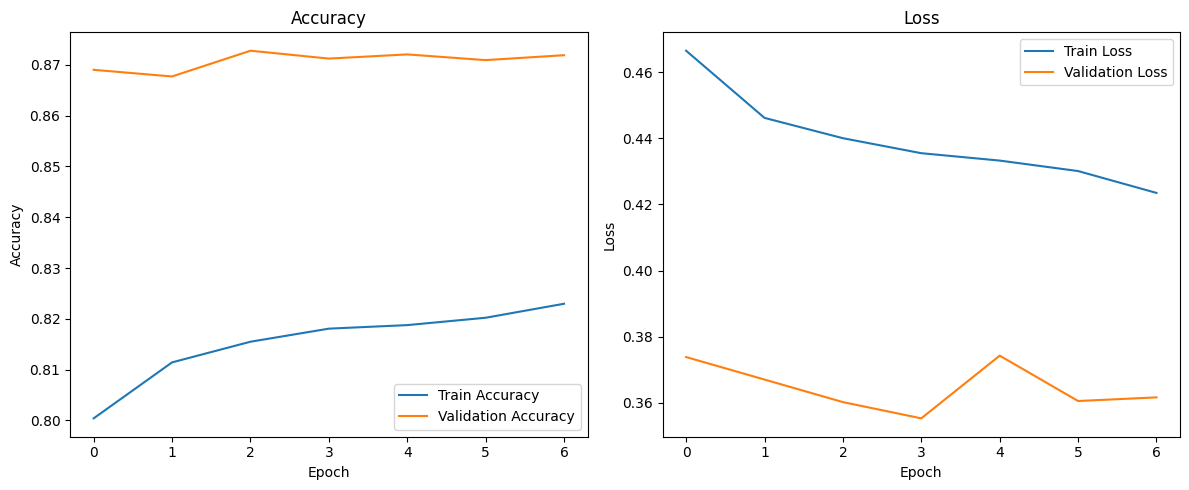

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
# os.makedirs("../../results/images", exist_ok=True)
# plt.savefig("../../results/images/03_final_training_plot.png")
plt.show()

1030/1030 [==============================] - 16s 15ms/step
              precision    recall  f1-score   support

        Open       0.90      0.78      0.84     13909
      Closed       0.85      0.94      0.89     19042

    accuracy                           0.87     32951
   macro avg       0.88      0.86      0.87     32951
weighted avg       0.87      0.87      0.87     32951



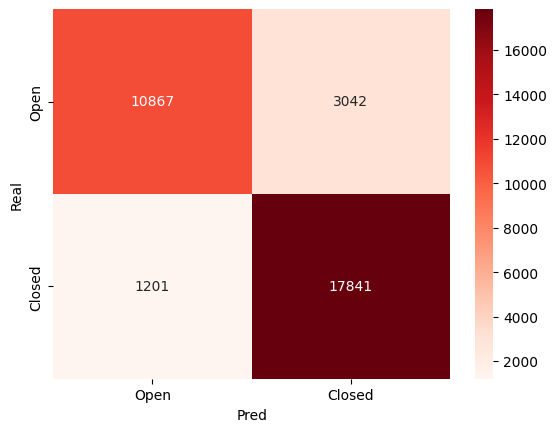

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_generator.reset()
preds=model.predict(val_generator)
pred_labels=(preds > 0.5).astype(int)
true_labels=val_generator.classes

report=classification_report(true_labels, pred_labels, target_names=["Open", "Closed"])
print(report)

conf_matrix=confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Open", "Closed"], yticklabels=["Open", "Closed"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

전반적으로 loss값이 너무 높음 -> 예측 확률이 확실하지 않음 -> 0.5 부근의 예측이 많음  
즉 맞긴 맞는데 확실치 않음  

다음 진행:
  - Dropout 0.3 정도로 재조정  
  - class_weight 없이 동일 구조로 재학습  